In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
from sklearn.metrics import make_scorer
import warnings
import pickle
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from category_encoders.target_encoder import TargetEncoder
warnings.filterwarnings('ignore')
import lightgbm as lgb
import pandas as pd 
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
import os
from skopt.space import Real, Categorical, Integer
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from sklearn.metrics import roc_auc_score        
        
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score ,confusion_matrix
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import RobustScaler
from itertools import combinations       


/kaggle/input/cross-sell/test_av.csv
/kaggle/input/cross-sell/train_av.csv


In [2]:
# Pickle save/load

def pickle_save(filename,obj):
    outfile = open(filename,'wb')
    pickle.dump(obj,outfile)
    outfile.close()
    
def pickle_load(filename):
    infile = open(filename,'rb')
    obj = pickle.load(infile)
    infile.close()    
    return obj


In [3]:
# Below is the function for adding features based on the frequecy

def frequency_encoding(column_name,output_column_name,df):
    fe_pol = (df.groupby(column_name).size()) / len(df)
    df[output_column_name] = df[column_name].apply(lambda x : fe_pol[x])
    return fe_pol

In [4]:
# Below is the function for adding aggregate features on data frame, particularly using 
# mean, max, min, std, count, nunique various different levels

def agg_func(df):
    region_code_cat_agg = df.groupby(['Region_Code','Is_Active','Credit_Product']).agg({'Occupation': ['nunique','count'],
                                                         'Gender': ['nunique','count'] ,
                                                         'Channel_Code': ['nunique','count'] ,
                                                         'Credit_Product': ['nunique','count'] ,
                                                         'Is_Active': ['nunique','count']})
    region_code_cat_agg.columns = ['region_code_cat_agg' + '_'.join(c).strip('_') for c in region_code_cat_agg.columns]
    df = pd.merge(df, region_code_cat_agg, on = ['Region_Code','Is_Active','Credit_Product'], how='left')

    occupation_cat_agg = df.groupby(['Occupation','Channel_Code']).agg({'Occupation': ['nunique','count'],
                                                         'Gender': ['nunique','count'] ,
                                                         'Channel_Code': ['nunique','count'] ,
                                                         'Credit_Product': ['nunique','count'] ,
                                                         'Is_Active': ['nunique','count']})
    occupation_cat_agg.columns = ['occupation_cat_agg' + '_'.join(c).strip('_') for c in occupation_cat_agg.columns]
    df = pd.merge(df, occupation_cat_agg, on = ['Occupation','Channel_Code'], how='left')

    channel_code_cat_agg = df.groupby(['Channel_Code','Credit_Product','Occupation','Is_Active']).agg({'Occupation': ['nunique','count'],
                                                         'Gender': ['nunique','count'] ,
                                                         'Channel_Code': ['nunique','count'] ,
                                                         'Credit_Product': ['nunique','count'] ,
                                                         'Is_Active': ['nunique','count']})
    channel_code_cat_agg.columns = ['channel_code_cat_agg' + '_'.join(c).strip('_') for c in channel_code_cat_agg.columns]
    df = pd.merge(df, channel_code_cat_agg, on = ['Channel_Code','Credit_Product','Occupation','Is_Active'], how='left')

    credit_product_cat_agg = df.groupby(['Credit_Product','Occupation','Is_Active']).agg({'Occupation': ['nunique','count'],
                                                         'Gender': ['nunique','count'] ,
                                                         'Channel_Code': ['nunique','count'] ,
                                                         'Credit_Product': ['nunique','count'] ,
                                                         'Is_Active': ['nunique','count']})
    credit_product_cat_agg.columns = ['credit_product_cat_agg' + '_'.join(c).strip('_') for c in credit_product_cat_agg.columns]
    df = pd.merge(df, credit_product_cat_agg, on = ['Credit_Product','Occupation','Is_Active'], how='left')

    is_active_cat_agg = df.groupby(['Is_Active','Occupation']).agg({'Occupation': ['nunique','count'],
                                                         'Gender': ['nunique','count'] ,
                                                         'Channel_Code': ['nunique','count'] ,
                                                         'Credit_Product': ['nunique','count'] ,
                                                         'Is_Active': ['nunique','count']})
    is_active_cat_agg.columns = ['is_active_cat_agg' + '_'.join(c).strip('_') for c in is_active_cat_agg.columns]
    df = pd.merge(df, is_active_cat_agg, on = ['Is_Active','Occupation'], how='left')
    region_code_agg = df.groupby(['Region_Code']).agg({'Age': ['mean', 'max', 'min','std'],
                                     'Vintage': ['mean', 'max', 'min','std'],
                                     'Avg_Account_Balance': ['mean', 'max', 'min','std']
                                                         })
    region_code_agg.columns = ['region_code_agg' + '_'.join(c).strip('_') for c in region_code_agg.columns]
    df = pd.merge(df, region_code_agg, on = ['Region_Code'], how='left')

    occupation_agg = df.groupby(['Occupation']).agg({'Age': ['mean', 'max', 'min','std'],
                                     'Vintage': ['mean', 'max', 'min','std'],
                                     'Avg_Account_Balance': ['mean', 'max', 'min','std']
                                                         })
    occupation_agg.columns = ['occupation_agg' + '_'.join(c).strip('_') for c in occupation_agg.columns]
    df = pd.merge(df, occupation_agg, on = ['Occupation'], how='left')

    channel_code_agg = df.groupby(['Channel_Code']).agg({'Age': ['mean', 'max', 'min','std'],
                                     'Vintage': ['mean', 'max', 'min','std'],
                                     'Avg_Account_Balance': ['mean', 'max', 'min','std']
                                                         })
    channel_code_agg.columns = ['channel_code_agg' + '_'.join(c).strip('_') for c in channel_code_agg.columns]
    df = pd.merge(df, channel_code_agg, on = ['Channel_Code'], how='left')

    credit_product_agg = df.groupby(['Credit_Product']).agg({'Age': ['mean', 'max', 'min','std'],
                                     'Vintage': ['mean', 'max', 'min','std'],
                                     'Avg_Account_Balance': ['mean', 'max', 'min','std']
                                                         })
    credit_product_agg.columns = ['credit_product_agg' + '_'.join(c).strip('_') for c in credit_product_agg.columns]
    df = pd.merge(df, credit_product_agg, on = ['Credit_Product'], how='left')

    is_active_agg = df.groupby(['Is_Active']).agg({'Age': ['mean', 'max', 'min','std'],
                                     'Vintage': ['mean', 'max', 'min','std'],
                                     'Avg_Account_Balance': ['mean', 'max', 'min','std']
                                                         })
    is_active_agg.columns = ['is_active_agg' + '_'.join(c).strip('_') for c in is_active_agg.columns]
    df = pd.merge(df, is_active_agg, on = ['Is_Active'], how='left')
    return df

In [5]:
# Below is the function for target encoding

def tar_encoder():
    train_df=df.loc[df.train_or_test.isin(['train'])]
    test_df=df.loc[df.train_or_test.isin(['test'])]
    cat_cols=list(cat_cols)
    TE_encoder = TargetEncoder()

    train_df[cat_cols] = TE_encoder.fit_transform(train_df[cat_cols], train_df['Is_Lead'])
    test_df[cat_cols] = TE_encoder.transform(test_df[cat_cols])


In [6]:
# Below is the function for label encoding 

def lab_encoder(df):
    le = LabelEncoder()
    le_list = []
    for col in cat_cols:
        df[col]= df[col].astype('str')
        df[col]= le.fit_transform(df[col])
        col = dict(zip(le.classes_, le.transform(le.classes_)))
        le_list.append(col)
    return df,le_list

## Preproccessing and feature generation

In [7]:
# Loading train data

train = pd.read_csv('/kaggle/input/cross-sell/train_av.csv')
print(train.shape)

train.head()

(245725, 11)


,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [8]:
# Loading test data

test = pd.read_csv('/kaggle/input/cross-sell/test_av.csv')

print(test.shape)

test.head()

(105312, 10)


,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [9]:
# Percentage of missing values

train.isnull().sum()*100/train.shape[0]

ID                      0.000000
Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Credit_Product         11.934073
Avg_Account_Balance     0.000000
Is_Active               0.000000
Is_Lead                 0.000000
dtype: float64

In [10]:
# Drop ID

train=train.drop(['ID'],axis=1)

In [11]:
# Delete Duplicate rows 

print('Before: ',train.duplicated().sum())
train.drop_duplicates(keep='first',inplace = True)
print('After: ',train.duplicated().sum())

Before:  21
After:  0


In [12]:
# Percentage of positive class

is_lead = train['Is_Lead'].value_counts()
print('% of positive class in dataset: ',is_lead[1]/train.shape[0])

% of positive class in dataset:  0.23722853514798295


With above statistic it is clear that data is imbalanced

In [13]:
# Description of data

train.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245704.000000,245704.000000,2.457040e+05,245704.000000
mean,43.857349,46.960884,1.128407e+06,0.237229
std,14.828552,32.353652,8.529483e+05,0.425384
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.945965e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


### Data Visulization (Train vs Test)

Text(0.5, 1.0, 'is_lead')

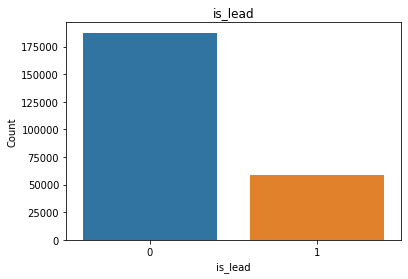

In [14]:
is_lead = train["Is_Lead"].value_counts().rename('Count')
plt.xlabel("is_lead")
plt.ylabel('Count')
sns.barplot(is_lead.index , is_lead.values).set_title('is_lead')

[Text(0.5, 1.0, 'Test')]

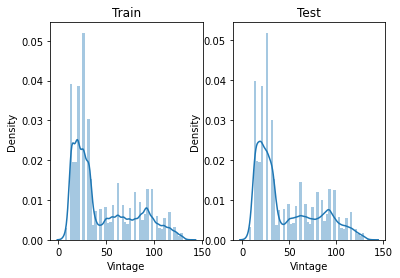

In [15]:
f, axes = plt.subplots(1, 2)
sns.distplot(train['Vintage'], ax=axes[0]).set(title='Train')
sns.distplot(test['Vintage'], ax=axes[1]).set(title='Test')

[Text(0.5, 1.0, 'Test')]

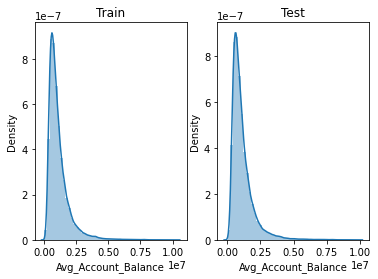

In [16]:
f, axes = plt.subplots(1, 2)
sns.distplot(train['Avg_Account_Balance'], ax=axes[0]).set(title='Train')
sns.distplot(test['Avg_Account_Balance'], ax=axes[1]).set(title='Test')

The above feature is highley skewed, it can be converted to normal distribution using boxcox transformation

[Text(0.5, 1.0, 'Test')]

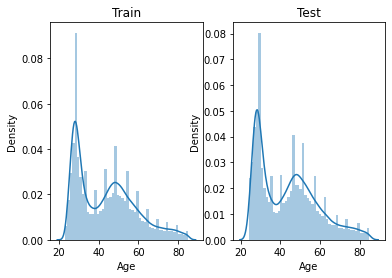

In [17]:
f, axes = plt.subplots(1, 2)
sns.distplot(train['Age'], ax=axes[0]).set(title='Train')
sns.distplot(test['Age'], ax=axes[1]).set(title='Test')

It can be observed with the distribution that AGE can be further divided in 4 categories using a discretizer.

In [18]:
# Adding a test/train identifier 
train['train_or_test']='train'
test['train_or_test']='test'

In [19]:
# Combining dataset
df=pd.concat([train,test],axis=0)

In [20]:
# Categorical and Numerical columns 
cat_cols = set(df.select_dtypes(include = 'object'))-set(['train_or_test','ID'])
num_cols = set(df.select_dtypes(include=['int64','float64']))


In [21]:
#Feature generation using Frequency encoding
fe_enc = []
fe_enc_single = []
comb = combinations(cat_cols, 2) 
comb_list = list(comb)
# For pair of features
for i in comb_list:  
    df[f'{i[0]}_{i[1]}']=df[i[0]].astype(str)+'_'+df[i[1]].astype(str)
    fe = frequency_encoding(f'{i[0]}_{i[1]}',f'{i[0]}_{i[1]}',df)
    fe_enc.append(fe)

# For individual feature    
for i in list(cat_cols):  
    if i!='Credit_Product':
        df[str(i)+'fe']=df[i].astype(str)
        fe = frequency_encoding(i,str(i)+'fe',df)
        fe_enc_single.append(fe)

In [22]:
#Missing value imputation
df['Credit_Product']=df['Credit_Product'].fillna('nan')

### Feature Encoding

In [23]:
# Label Encoding 

df,le_list = lab_encoder(df)


### Missing Values imputation using KNN imputer

In [24]:
#Missing Values imputation
#df['Credit_Product']=df['Credit_Product'].replace(2,np.nan)

# for i in num_cols:
#     df[i]=df[i]/df[i].max()
# df[num_cols]

# X_temp=df.drop(['Is_Lead','train_or_test','ID'],axis=1)
# imputer = KNNImputer()
# imputer.fit(X_temp)
# # transform the dataset
# Xtrans = imputer.transform(X_temp)
# X_=pd.DataFrame(Xtrans,columns=X_temp.columns)
# df['Credit_Product']=X_['Credit_Product'].values

The above technique did not work well

In [25]:
#Data segregation into train and test
train_df=df.loc[df.train_or_test.isin(['train'])]
test_df=df.loc[df.train_or_test.isin(['test'])]

In [26]:
#Removal of unneccasry columns
train_df=train_df.drop(['train_or_test','ID'],axis=1)
test_df=test_df.drop(['train_or_test','Is_Lead'],axis=1)
ID=test_df['ID']
test_df=test_df.drop(['ID'],axis=1)

In [27]:
#X,Y split
Y=train_df['Is_Lead']
X=train_df.drop(['Is_Lead'],axis=1)

# Model training

### Base models for Stacked Classifier

In [28]:
#Preparing for stacked classifier 
estimators = [
     ('xg', XGBClassifier(n_estimators=500,scale_pos_weight=1.78,random_state=42)), 
     ('cb',CatBoostClassifier(random_state=42,scale_pos_weight=1.78, custom_metric=['AUC'])), 
     ('lbg',lgb.LGBMClassifier(scale_pos_weight=1.78,verbose=-1,verbose_eval=False))]
      

### Meta model on catboost

In [29]:
#Model training 
stk1=StackingClassifier(estimators=estimators, final_estimator=CatBoostClassifier(learning_rate = 0.03,random_state=42,scale_pos_weight=1.78, custom_metric=['AUC']))
stk1.fit(X,Y)
y_spred1=stk1.predict_proba(test_df)[:, 1]

[06:54:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.108054
0:	learn: 0.6277600	total: 121ms	remaining: 2m
1:	learn: 0.5787009	total: 187ms	remaining: 1m 33s
2:	learn: 0.5410433	total: 249ms	remaining: 1m 22s
3:	learn: 0.5128177	total: 311ms	remaining: 1m 17s
4:	learn: 0.4936026	total: 364ms	remaining: 1m 12s
5:	learn: 0.4766067	total: 432ms	remaining: 1m 11s
6:	learn: 0.4634674	total: 496ms	remaining: 1m 10s
7:	learn: 0.4534282	total: 559ms	remaining: 1m 9s
8:	learn: 0.4455763	total: 622ms	remaining: 1m 8s
9:	learn: 0.4389139	total: 684ms	remaining: 1m 7s
10:	learn: 0.4339350	total: 746ms	remaining: 1m 7s
11:	learn: 0.4299858	total: 808ms	remaining: 1m 6s
12:	learn: 0.4267428	total: 874ms	remaining: 1m 6s
13:	learn: 0.4246701	total: 931ms	remaining: 1m 5s
14:	learn: 

In [31]:
# Save pickles 

feat_map = dict(zip(cat_cols, le_list))
pickle_save('stk1',stk1)
pickle_save('dataframe',df)
pickle_save('feat_map',feat_map)
pickle_save('category_columns',cat_cols)
pickle_save('comb_list',comb_list)
pickle_save('fe_enc_single',fe_enc_single)
pickle_save('fe_enc',fe_enc)

In [ ]:
sample=pd.DataFrame({'ID':ID,'Is_Lead':y_spred1})
sample.to_csv("cat_final_v34.csv", index = False)
sample

In [ ]:
from IPython.display import FileLink
FileLink(r'cat_final_v34.csv')

### Standalone Catboost ensemble
* Below is the model used for 70% of the time for training, it uses blending on seed with 3 ensemble model.
* Weights are assigned to each model based on the auc score in such a way that least weight is assigned to a model with highest auc score to penalize the imbalance of class which worked well.
* With the below model highest auc score on leaderboard achieved was 0.872717051326166 with the similar above configuration except encoding used was target encoding. 

In [ ]:
oof_pred  = np.zeros((len(train),))
y_pred_final   = np.zeros((len(test),))
n_splits  = 5

kf=StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=28052021)

for i,(train_idx,val_idx) in enumerate(kf.split(X,Y)):  

    wghts  = [0]*3
    test_roc_score   = []


    X_train, y_train = X.iloc[train_idx,:], Y.iloc[train_idx]

    X_val, y_val = X.iloc[val_idx, :], Y.iloc[val_idx]


    print('\nFold: {}\n'.format(i+1))

    model1 = CatBoostClassifier(learning_rate = 0.03,random_state=41,scale_pos_weight=1.78, custom_metric=['AUC'])
    model1.fit(X_train,y_train,cat_features=cat_cols,eval_set=(X_val, y_val),early_stopping_rounds=30,verbose=100)
    testpred1 = model1.predict_proba(X_val)[:,1]
    test_roc_score.append(roc_auc_score(y_val, testpred1))
    print("Test ROC AUC for model 1: %.4f"%(roc_auc_score(y_val, testpred1)))

    model2 = CatBoostClassifier(learning_rate = 0.04,random_state=42,scale_pos_weight=1.78, custom_metric=['AUC'])
    model2.fit(X_train,y_train,cat_features=cat_cols,eval_set=(X_val, y_val),early_stopping_rounds=40,verbose=100)
    testpred2 = model2.predict_proba(X_val)[:,1]
    test_roc_score.append(roc_auc_score(y_val, testpred2))
    print("Test ROC AUC for model 2: %.4f"%(roc_auc_score(y_val, testpred2)))

    model3 = CatBoostClassifier(learning_rate = 0.05,random_state=43,scale_pos_weight=1.78, custom_metric=['AUC'])
    model3.fit(X_train,y_train,cat_features=cat_cols,eval_set=(X_val, y_val),early_stopping_rounds=20,verbose=100)
    testpred3 = model3.predict_proba(X_val)[:,1]
    test_roc_score.append(roc_auc_score(y_val, testpred3))
    print("Test ROC AUC for model 3: %.4f"%(roc_auc_score(y_val, testpred3)))

    wghts = np.exp(-1000*np.array(test_roc_score/sum(test_roc_score)))
    wghts = wghts/sum(wghts)

    val_pred   = wghts[0]*testpred1+wghts[1]*testpred2 +wghts[2]*testpred3
    print('validation roc_auc_score fold-',i+1,': ',roc_auc_score(y_val, val_pred))

    oof_pred[val_idx] = val_pred
    y_pred_final += (wghts[0]*model1.predict_proba(test_df)[:,1]+wghts[1]*model2.predict_proba(test_df)[:,1]+wghts[2]*model3.predict_proba(test_df)[:,1])/(n_splits)

    print('\n')

print('OOF ROC_AUC_Score:- ',(roc_auc_score(Y,oof_pred)))
